<a href="https://colab.research.google.com/github/melinadwisafitri/skripsi_price_predict/blob/main/model%20manual.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import urllib.request
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

from tensorflow.data import Dataset
from keras.losses import Huber
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from keras.layers import Conv1D, LSTM, Dense, Dropout
from keras.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, RootMeanSquaredError

def time_step_generator(data, time_size, batch_size, shuffle_data):
  generate_data = Dataset.from_tensor_slices(data) # generate data series menjadi tensor
  add_window_time_step = generate_data.window(time_size+1, shift=1, drop_remainder=True) # membuat data kedalam kolom window yang baru
  print(add_window_time_step)
  flatten_window = add_window_time_step.flat_map(lambda window : window.batch(time_size+1)) # hasil pertambahan step data akan digabung menjadi satu array
  tuple_feature_label = flatten_window.map(lambda window: (window[:-1], window[-1]))# data akan dirubah menjadi feature dan label dengan ketentuan 1 data terakhir sabagai label
  shuffle_data = tuple_feature_label.shuffle(shuffle_data) # data yang sudah jadi akan di random sesuai dengan ukuran random data
  batch_window = shuffle_data.batch(batch_size).prefetch(1) # data akan disusun menjadi batch-batch tertentu sesuai dengan kebutuhan
  
  return batch_window

def forecast_predict(model, data, time_size, batch_size, shuffle_data):
  generate_data = Dataset.from_tensor_slices(data)
  add_window_step = generate_data.window(time_size, shift=1, drop_remainder=True)
  flatten_window = add_window_step.flat_map(lambda window: window.batch(time_size))
  batch_window = flatten_window.batch(batch_size).prefetch(1)
  model_predict = model.predict(batch_window)
  return model_predict

In [2]:
data_url = 'https://github.com/melinadwisafitri/skripsi_price_predict/blob/main/data_pangan/data_fixs/data_harga_bahan_pangan_indonesia.csv?raw=true'
urllib.request.urlretrieve(data_url, 'data_pangan_indonesia.csv')

data_pangan = pd.read_csv('data_pangan_indonesia.csv')
data_pangan.columns = data_pangan.columns.str.replace(' (kg)', '', regex=False).str.replace('(kg)', '', regex=False).str.replace(' ', '_').str.lower()
data_pangan['date'] = pd.to_datetime(data_pangan.date)
data_pangan = data_pangan.set_index('date')

<function matplotlib.pyplot.show(*args, **kw)>

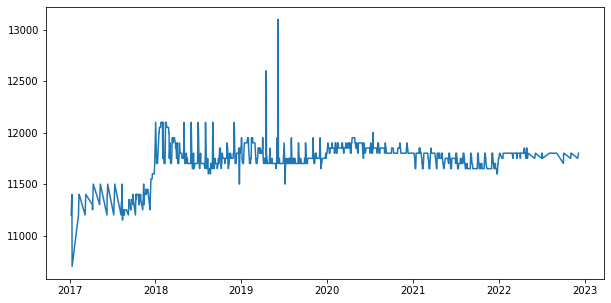

In [3]:
data_pangan = data_pangan.sort_index()
plt.figure(figsize=(10, 5))
plt.plot(data_pangan.index.values, data_pangan.beras.values)
plt.show

In [4]:
from os import initgroups
import scipy.stats as stats
Q1 = data_pangan.quantile(q=.25)
Q3 = data_pangan.quantile(q=.75)
IQR = Q3-Q1

low = Q1-1.5*IQR
high = Q3+1.5*IQR

IQRs = data_pangan.apply(stats.iqr)

lows = Q1-1.5*IQRs
highs = Q3+1.5*IQRs
# up = data_pangan['minyak_goreng'] >= (highs)
# low = data_pangan['minyak_goreng'] <= (lows)

# lower = np.where(low)
# uper = np.where(up)

# data_pangan['minyak_goreng']
clean = data_pangan[~((data_pangan < lows) | (data_pangan > highs)).any(axis=1)]

# out_bawang_putih = data_pangan.bawang_putih.loc[(data_pangan['bawang_putih'] > low) & (data_pangan['bawang_putih'] < high)]

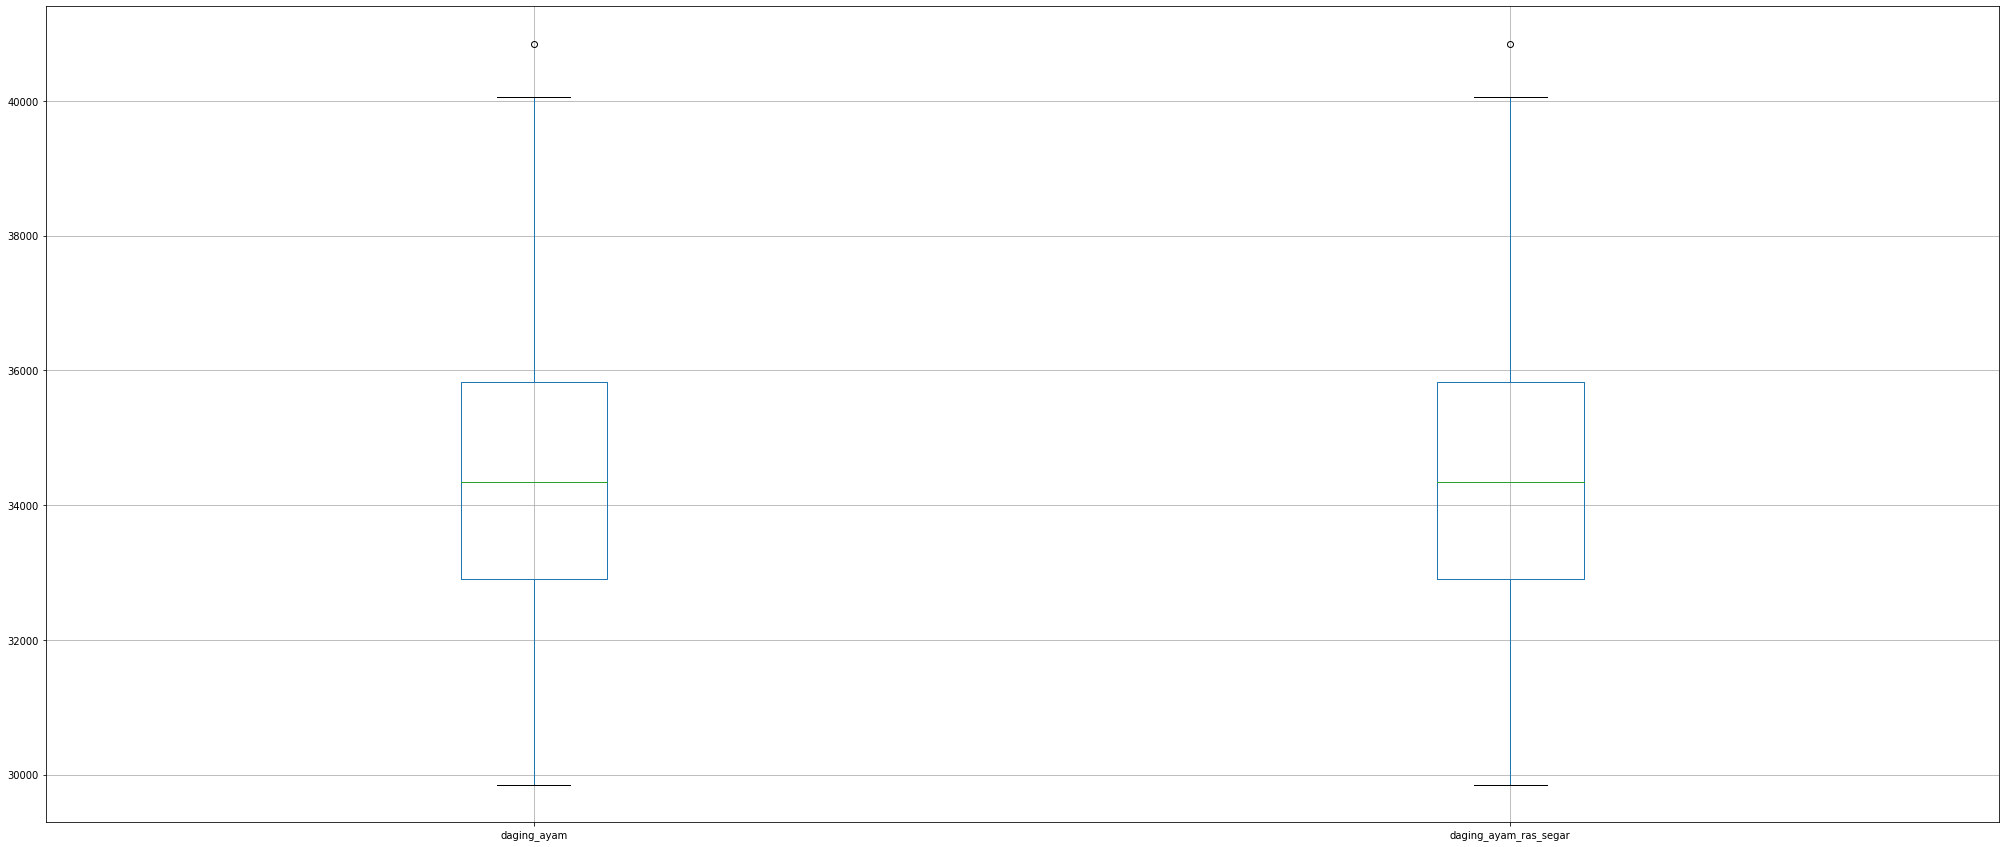

In [5]:
clean.iloc[:, 7:9].boxplot(figsize=(35, 15))

In [6]:
beras = data_pangan['beras'].values
date = data_pangan.index.values
x_train, x_test, y_train, y_test = train_test_split(beras, date, test_size=0.2, random_state=False, shuffle=False)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=False, shuffle=False)
scaller = MinMaxScaler(feature_range=(0, 1))
scal_beras = scaller.fit_transform(x_train.reshape(-1, 1))
train_beras = time_step_generator(scal_beras, time_size=300, batch_size=10, shuffle_data=1000)
test_beras = time_step_generator(scaller.fit_transform(x_test.reshape(-1, 1)), time_size=150, batch_size=5, shuffle_data=100)
val_beras = time_step_generator(scaller.fit_transform(x_val.reshape(-1, 1)), time_size=80, batch_size=5, shuffle_data=1000)
len(beras)

<WindowDataset element_spec=DatasetSpec(TensorSpec(shape=(1,), dtype=tf.float64, name=None), TensorShape([]))>
<WindowDataset element_spec=DatasetSpec(TensorSpec(shape=(1,), dtype=tf.float64, name=None), TensorShape([]))>
<WindowDataset element_spec=DatasetSpec(TensorSpec(shape=(1,), dtype=tf.float64, name=None), TensorShape([]))>


1174

In [7]:
bamer = data_pangan.bawang_merah.values
datess = data_pangan.index.values
x_trains, x_tests, y_train, y_tests = train_test_split(bamer, datess, test_size=0.2, random_state=False, shuffle=False)
x_trains, x_vals, y_trains, y_vals = train_test_split(x_trains, y_train, test_size=0.1, random_state=False, shuffle=False)
scaler = MinMaxScaler(feature_range=(0, 1))
scal_train_bamer = scaller.fit_transform(x_trains.reshape(-1, 1))
scal_test_bamer = scaller.fit_transform(x_tests.reshape(-1, 1))
scal_val_bamer = scaller.fit_transform(x_vals.reshape(-1, 1))
train_bamer = time_step_generator(scal_train_bamer, time_size=500, batch_size=5, shuffle_data=100)
test_bamer= time_step_generator(scal_test_bamer, time_size=150, batch_size=5, shuffle_data=100)
val_bamer = time_step_generator(scal_val_bamer, time_size=80, batch_size=5, shuffle_data=100)
len(x_tests)

<WindowDataset element_spec=DatasetSpec(TensorSpec(shape=(1,), dtype=tf.float64, name=None), TensorShape([]))>
<WindowDataset element_spec=DatasetSpec(TensorSpec(shape=(1,), dtype=tf.float64, name=None), TensorShape([]))>
<WindowDataset element_spec=DatasetSpec(TensorSpec(shape=(1,), dtype=tf.float64, name=None), TensorShape([]))>


235

In [8]:
model= Sequential([
    Conv1D(filters=3, kernel_size=2, activation='relu', strides=1, padding='causal', input_shape=[None, 1], name='inputcnn'),
    LSTM(4, return_sequences=True),
    LSTM(14),
    Dense(30, activation='relu'),
    Dropout(0.25),
    Dense(1, name="output")
    # tf.keras.layers.Lambda(lambda x: x * 100.0)
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputcnn (Conv1D)           (None, None, 3)           9         
                                                                 
 lstm (LSTM)                 (None, None, 4)           128       
                                                                 
 lstm_1 (LSTM)               (None, 14)                1064      
                                                                 
 dense (Dense)               (None, 30)                450       
                                                                 
 dropout (Dropout)           (None, 30)                0         
                                                                 
 output (Dense)              (None, 1)                 31        
                                                                 
Total params: 1,682
Trainable params: 1,682
Non-trainabl

In [9]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse', metrics=['mae', 'mape',])

In [10]:
a = [11200, 11200, 11300, 11200, 11200, 11200, 11200, 11250, 11150, 11200, 11250]
data = pd.DataFrame(a, columns=['data'])

In [11]:
s_train = scaller.fit_transform(data.values.reshape(-1, 1))
traindata = time_step_generator(s_train, time_size=5, batch_size=1, shuffle_data=5)
his = model.fit(traindata, epochs=10)

<WindowDataset element_spec=DatasetSpec(TensorSpec(shape=(1,), dtype=tf.float64, name=None), TensorShape([]))>
Epoch 1/10
6/6 [==============================] - 10s 171ms/step - loss: 0.2022 - mae: 0.3879 - mape: 442699.6250
Epoch 2/10
6/6 [==============================] - 0s 12ms/step - loss: 0.1905 - mae: 0.3774 - mape: 1337817.1250
Epoch 3/10
6/6 [==============================] - 0s 11ms/step - loss: 0.1743 - mae: 0.3638 - mape: 6491322.0000
Epoch 4/10
6/6 [==============================] - 0s 14ms/step - loss: 0.1593 - mae: 0.3522 - mape: 13386545.0000
Epoch 5/10
6/6 [==============================] - 0s 16ms/step - loss: 0.1389 - mae: 0.3188 - mape: 8408891.0000
Epoch 6/10
6/6 [==============================] - 0s 12ms/step - loss: 0.1168 - mae: 0.3026 - mape: 17983714.0000
Epoch 7/10
6/6 [==============================] - 0s 17ms/step - loss: 0.1185 - mae: 0.2987 - mape: 29191074.0000
Epoch 8/10
6/6 [==============================] - 0s 16ms/step - loss: 0.1139 - mae: 0.2931 - 

In [12]:
history = model.fit(train_bamer, epochs=15, validation_data=val_bamer)

Epoch 1/15
69/69 [==============================] - 33s 480ms/step - loss: 0.0507 - mae: 0.1736 - mape: 80.2305 - val_loss: 0.0871 - val_mae: 0.2656 - val_mape: 44.0562
Epoch 2/15
69/69 [==============================] - 22s 313ms/step - loss: 0.0416 - mae: 0.1561 - mape: 68.0456 - val_loss: 0.0618 - val_mae: 0.2202 - val_mape: 40.3110
Epoch 3/15
69/69 [==============================] - 22s 316ms/step - loss: 0.0381 - mae: 0.1534 - mape: 65.3053 - val_loss: 0.0510 - val_mae: 0.1954 - val_mape: 38.7893
Epoch 4/15
69/69 [==============================] - 22s 319ms/step - loss: 0.0382 - mae: 0.1482 - mape: 65.3133 - val_loss: 0.0426 - val_mae: 0.1712 - val_mape: 38.3268
Epoch 5/15
69/69 [==============================] - 20s 287ms/step - loss: 0.0351 - mae: 0.1430 - mape: 62.6903 - val_loss: 0.0418 - val_mae: 0.1665 - val_mape: 38.2684
Epoch 6/15
69/69 [==============================] - 20s 283ms/step - loss: 0.0371 - mae: 0.1446 - mape: 59.8504 - val_loss: 0.0530 - val_mae: 0.2008 - val_

In [13]:
model.evaluate(test_beras)

17/17 [==============================] - 0s 19ms/step - loss: 0.0288 - mae: 0.1467 - mape: 19.8322


[0.02876623161137104, 0.14673221111297607, 19.832162857055664]

In [14]:
model.layers[0].trainable_weights[0]
w =  model.layers[0].get_weights()[0]
w

array([[[-0.17298669, -0.62184376,  0.78596735]],

       [[-0.17038941, -0.36430287, -0.1691055 ]]], dtype=float32)

In [15]:
# print(model.layers[1].trainable_weights)
units = int(int(model.layers[1].trainable_weights[0].shape[1])/4)

w = model.layers[1].get_weights()[0]
u = model.layers[1].get_weights()[1]
b = model.layers[1].get_weights()[2]

w_i = w[:, units]
w_f = w[:, units: units * 2]
w_c = w[:, units * 2: units * 3]
w_o = w[:, units*3]

U_i = u[:, :units]
U_f = u[:, units: units * 2]
U_c = u[:, units * 2: units * 3]
U_o = u[:, units * 3:]

b_i = b[:units]
b_f = b[units: units * 2]
b_c = b[units * 2: units * 3]
b_o = b[units * 3:]

print((int(model.layers[0].trainable_weights[0].shape[1])/4)*2)
print((int(model.layers[0].trainable_weights[0].shape[1])/4)*3)
print(model.layers[1].get_weights()[0].shape)
print(units)

print(f'wi= {w_i}\n wf = {w_f}\n wc= {w_c}\n wo= {w_o}')
print(f'ui= {U_i}\n uf = {U_f}\n uc= {U_c}\n uo= {U_o}')
print(f'bi= {b_i}\n bf = {b_f}\n bc= {b_c}\n bo= {b_o}')

0.5
0.75
(3, 16)
4
wi= [-0.51644313  0.49953192 -0.05151647]
 wf = [[-0.51644313  0.48678523 -0.24229538  0.35304618]
 [ 0.49953192 -0.21433517  0.07588381 -0.38434252]
 [-0.05151647 -0.4004726   0.27104217  0.21568328]]
 wc= [[-0.4179741   0.43473482 -0.17114696  0.3637064 ]
 [ 0.19193697  0.4327104   0.18310642  0.42792863]
 [ 0.5840498  -0.47578284 -0.00545636  0.51920503]]
 wo= [0.29653543 0.25088537 0.34028867]
ui= [[ 0.03416362 -0.37206432 -0.1595724   0.45960626]
 [ 0.26880231 -0.03288318  0.01935077 -0.5612814 ]
 [ 0.16024128  0.1315533   0.08657385  0.03816709]
 [ 0.02940691 -0.22599164  0.27932402 -0.09097397]]
 uf = [[ 0.10717289 -0.05981723 -0.10997795  0.11292464]
 [ 0.19272867 -0.05353089 -0.11597243  0.26547375]
 [ 0.23853077  0.4743575  -0.56898457 -0.13221353]
 [ 0.16562542  0.1863105   0.29561436  0.35178587]]
 uc= [[-0.2437538  -0.23761006  0.08961084  0.42072457]
 [-0.08598022 -0.16712548  0.05186037  0.45870003]
 [-0.21713415 -0.15200284 -0.04141995 -0.33712304]
 [

In [16]:
from keras import models 
from keras import layers

def define_model(len_ts,
                 hidden_neurons = 1,
                 nfeature=1,
                 batch_size=None,
                 stateful=False):
    in_out_neurons = 1
    
    inp = layers.Input(batch_shape= (batch_size, len_ts, nfeature),
                       name="input")  

    rnn = layers.LSTM(hidden_neurons, 
                    return_sequences=True,
                    stateful=stateful,
                    name="RNN")(inp)

    dens = layers.TimeDistributed(layers.Dense(in_out_neurons,name="dense"))(rnn)
    model = models.Model(inputs=[inp],outputs=[dens])
    
    model.compile(loss="mean_squared_error",
                  sample_weight_mode="temporal",
                  optimizer="rmsprop")
    return(model,(inp,rnn,dens))

In [17]:
# mae = history.history['mae']
# val_mae = history.history['val_mae']
# epoch = range(len(mae))

# plt.plot(epoch, mae)
# plt.plot(epoch, val_mae)
# plt.show

In [18]:
# from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
# # from keras.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, RootMeanSquaredError

# test_beras_1 = x_vals
# prediction = forecast_predict(model, test_beras_1, time_size=10, batch_size=10, shuffle_data=2)
# result = prediction.squeeze()
# results = result.reshape(-1, 1)
# results = scaller.inverse_transform(results)
# results = results.reshape(-1)
# data_test = x_vals[:-9]
# data_test = data_test.reshape(-1)

# data_new = pd.DataFrame()
# data_new['actual'] = data_test
# data_new['prediction'] = results.round()
# mae = mean_absolute_error(data_test, results)
# mape = mean_absolute_percentage_error(data_test, results)
# print(f"mae= {mae}\nmape= {mape}")
# data_new

In [19]:
# data_new.to_csv(r'data_frame.csv', index=False, header=True)

In [20]:
# dates = y_test[:-9]
# plt.figure(figsize=(10, 5))
# plt.plot(dates, data_test)
# plt.plot(dates, results)
# plt.show

In [21]:
# tested = pd.read_excel('tested.xlsx', skiprows=8)
# tested = tested.drop('No.', axis=1)
# tested = tested.T.reset_index()
# tested.columns = tested.loc[0]
# tested = tested.drop(0)

# tested = tested.rename(columns={'Komoditas(Rp)': 'Date'})
# test_beras = tested['Beras'].values
# minmaxtest = scaller.fit_transform(test_beras.reshape(-1, 1))
# prediction_1 = forecast_predict(model, minmaxtest, time_size=3, batch_size=1, shuffle_data=1000)
# result_1 = prediction_1.squeeze()
# results_1 = result_1.reshape(-1, 1)
# results_1 = scaller.inverse_transform(results_1).round(1)
# results_1 = results_1.reshape(-1)
# test_berass = test_beras[:-2]
# date = tested['Date']
# date = date[:-2]
# new = pd.DataFrame()
# new['date'] = date
# new['actual'] = test_berass
# new['prediction'] = results_1
# minn = minmaxtest.reshape(-1)
# minn = minn[:-2]
# mae = mean_absolute_error(test_berass, results_1)
# mape = mean_absolute_percentage_error(test_berass, results_1)
# mae, mape

In [22]:
# data = scal_test_bamer.reshape(1, -1)
# data_series = list(data)
# data_series = data_series[0].tolist()

# output = []
# step = len(scal_test_bamer) - 1
# i = 1
# while(i<=100):
#   if(len(data_series)>100):
#     input = np.array(data_series[1:])
#     print(f'{i} day with input {input}')
#     input = input.reshape(1, -1)
#     input = input.reshape((1, step, 1))
#     print(input)
#     y = model.predict(input, verbose=0)
#     print(f'{i} day output {y}')
#     data_series.extend(y[0].tolist())
#     data_series = data_series[1:]
#     output.extend(y.tolist())
#     i = i+1
#   else:
#     input = np.array(data_series)
#     input = input.reshape(1, step, 1)
#     y = model.predict(input, verbose=0)
#     print(y[0])
#     data_series.extend(y[0].tolist())
#     output.extend(y.tolist())
#     i = i+1

# np.array(scaller.inverse_transform(output)).round()

In [23]:
# from numpy import array
# from keras.models import Sequential
# from keras.layers import LSTM
# from keras.layers import Dense
# from keras.layers import Flatten
# from keras.layers import TimeDistributed
# from keras.layers.convolutional import Conv1D
# from keras.layers.convolutional import MaxPooling1D
 
# # split a univariate sequence into samples
# def split_sequence(sequence, n_steps):
# 	X, y = list(), list()
# 	for i in range(len(sequence)):
# 		# find the end of this pattern
# 		end_ix = i + n_steps
# 		# check if we are beyond the sequence
# 		if end_ix > len(sequence)-1:
# 			break
# 		# gather input and output parts of the pattern
# 		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
# 		X.append(seq_x)
# 		y.append(seq_y)
# 	return array(X), array(y)
 
# # define input sequence
# raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# # choose a number of time steps
# n_steps = 4
# # split into samples
# X, y = split_sequence(raw_seq, n_steps)
# # reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
# n_features = 1
# n_seq = 2
# n_steps = 2
# X = X.reshape((X.shape[0], n_seq, n_steps, n_features))
# print(X)
# # define model
# model = Sequential()
# model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
# model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
# model.add(TimeDistributed(Flatten()))
# model.add(LSTM(50, activation='relu'))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mse')
# # fit model
# model.fit(X, y, epochs=500, verbose=0)
# # demonstrate prediction
# x_input = array([60, 70, 80, 90])
# x_input = x_input.reshape((1, n_seq, n_steps, n_features))
# yhat = model.predict(x_input, verbose=0)
# print(yhat)